In [1]:
import torch
import torch.nn.functional as F
from task.TaskGenerator import GaussianTaskGenerator
import matplotlib.pyplot as plt

# Task setting
Define the task family and the possible priors on the parameters for meta-training the model

In [2]:
# Problem param
z_dim = 2
n_tasks = 1000

# Input space range
x_min = -100
x_max = 100

# Training task latent space range
min_mean = -40
max_mean = 40

min_std = 15
max_std = 35

# Prior on the offset task range
mu_min = -10
mu_max = 10

var_min = 0.1
var_max = 5

# Task generator creation
task_gen = GaussianTaskGenerator(x_min=x_min, x_max=x_max)

# Data creation
def sample_task(n_batches=10, test_perc=0, batch_size=128):
    #a = (min_a - max_a) * torch.rand(1) + max_a
    a = 1
    m = (min_mean - max_mean) * torch.rand(1) + max_mean
    s = (min_std - max_std) * torch.rand(1) + max_std
    
    data = task_gen.get_mixed_data_loader(amplitude=a, 
                                    mean=m,
                                    std=s,
                                    num_batches=n_batches,
                                    test_perc=test_perc, 
                                    batch_size=batch_size)
    return data, m, s

def sample_prior_dist(dim):
    mu_l = []
    var_l = []
    for i in range(dim):
        mu = (mu_min - mu_max) * torch.rand(1) + mu_max
        var = (var_min - var_max) * torch.rand(1) + var_max
        
        mu_l.append(mu)
        var_l.append(var)
    
    return mu_l, var_l
    
# Dataset creation
data_set = []
a_set = []
mean_set = []
std_set = []
param = []
for _ in range(n_tasks):
    data, mean, std = sample_task(n_batches=1, test_perc=0, batch_size=180)
    data_set.append(data)
    mean_set.append(mean)
    std_set.append(std)
    param.append((mean.item(), std.item()))
    
# Prior distribution on the next task
prior_dist = []
for _ in range(n_tasks):
    prior_dist.append(torch.Tensor(sample_prior_dist(z_dim)))

In [3]:
m = 0
for i in range(n_tasks):
    t = torch.abs(prior_dist[i][0]).max()
    if t > m:
        m = t
m

tensor(9.9995)

In [4]:
# Print some offset according to this procedure
for _ in range(10):
    t_idx = torch.randint(0, 1000, size=(1,))
    mu = prior_dist[t_idx][0]
    var = prior_dist[t_idx][1]
    print("Offset {} || Offset - mu {}".format(torch.normal(mu, var), 
                                               (torch.normal(mu, var)-prior_dist[t_idx][0])))

Offset tensor([-8.5248, 10.5932]) || Offset - mu tensor([-0.7206,  0.8767])
Offset tensor([ 1.7359, -5.8822]) || Offset - mu tensor([2.3547, 0.6012])
Offset tensor([-7.2045, -7.2695]) || Offset - mu tensor([-0.2332,  2.1969])
Offset tensor([ 1.4876, -4.8328]) || Offset - mu tensor([ 2.8279, -0.2491])
Offset tensor([6.3134, 1.8194]) || Offset - mu tensor([-9.3074,  0.0945])
Offset tensor([-9.5527, -8.5969]) || Offset - mu tensor([-4.6879, -0.7210])
Offset tensor([ 8.8636, -3.4360]) || Offset - mu tensor([0.7559, 0.7974])
Offset tensor([-4.6265,  5.1706]) || Offset - mu tensor([1.3912, 1.0669])
Offset tensor([-2.0823, -3.7626]) || Offset - mu tensor([-5.4263,  0.4887])
Offset tensor([9.3056, 7.4984]) || Offset - mu tensor([-2.4246, -5.9060])


# Inference network

In [5]:
# Define the network for inference on the latent space
class InferenceNetwork(torch.nn.Module):
    """
    Input:
        Previous latent space 
        sequence of data from the current task and old task at that point
        prior over the current task (expressed as vector mu and c)
    
    Output:
        - sample from the probability distribution over the latent space
        - mu and logvar from the posterior distribution
    """
    def __init__(self, n_in, z_dim):
        super(InferenceNetwork, self).__init__()
        self.z_dim = z_dim
        self.n_in = n_in
        
        self.enc1 = torch.nn.Linear(n_in, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=32, num_layers=2, batch_first=True)
        self.enc3 = torch.nn.Linear(32, 16)
        self.enc41 = torch.nn.Linear(16, z_dim)
        self.enc42 = torch.nn.Linear(16, z_dim)
        
    def encode(self, context, prev_z, prior, use_prev_state):
        # Compute batch number and lenght of the sequence
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        
        # Data preparation
        prev_z = prev_z.reshape(n_batch, 1, 2)
        prev_z = prev_z.repeat(1, seq_len, 1)
        
        prior = prior.reshape(n_batch, 1, 4)
        prior = prior.repeat(1, seq_len, 1)
        
        context = torch.cat([context, prev_z, prior], dim=2) 
        
        # Data processing
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        if use_prev_state:
            t, self.h = self.enc2(t, self.h)
        else:
            t, self.h = self.enc2(t)
        t = t[:, -1, :] # we are interested only in the last output of the sequence
        t = F.elu(t)
        t = F.elu(self.enc3(t))
        
        # Return encoded mu and logvar
        return  self.enc41(t), self.enc42(t)
        
    def reparameterize(self, mu, logvar):
        # Re-parametrization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context, prev_z, prior, use_prev_state=False):
        mu, logvar = self.encode(context, prev_z, prior, use_prev_state)
        z = self.reparameterize(mu=mu, logvar=logvar)
        return z, mu, logvar

    
    
# Define the network for inference on the latent space
class InferenceNetwork2(torch.nn.Module):
    """
    Input:
        Previous latent space 
        sequence of data from the current task and old task at that point
        prior over the current task (expressed as vector mu and c)
    
    Output:
        - sample from the probability distribution over the latent space
        - mu and logvar from the posterior distribution
    """
    def __init__(self, n_in, z_dim):
        super(InferenceNetwork2, self).__init__()
        self.z_dim = z_dim
        self.n_in = n_in
        
        self.enc1 = torch.nn.Linear(n_in, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=32, num_layers=2, batch_first=True)
        self.enc3 = torch.nn.Linear(32+z_dim*2+1, 16) # hidden + the prior + seq_len 
        self.enc41 = torch.nn.Linear(16, z_dim)
        self.enc42 = torch.nn.Linear(16, z_dim)
        
        self.h = None
        self.seq_len = 0
        
    def encode(self, context, prev_z, prior, use_prev_state):
        # Compute batch number and lenght of the sequence
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        
        # Data preparation
        prev_z = prev_z.reshape(n_batch, 1, 2)
        prev_z = prev_z.repeat(1, seq_len, 1)
        
        original_prior = prior
        if len(original_prior.shape) == 1:
            original_prior = original_prior.unsqueeze(0)
        prior = prior.reshape(n_batch, 1, 4)
        prior = prior.repeat(1, seq_len, 1)
        
        context = torch.cat([context, prev_z, prior], dim=2) 
        
        # Data processing
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        if use_prev_state and self.h is not None:
            t, self.h = self.enc2(t, self.h)
        else:
            t, self.h = self.enc2(t)
        t = t[:, -1, :] # we are interested only in the last output of the sequence
        t = F.elu(t)

        self.seq_len += seq_len 
        trust = torch.tensor([self.seq_len], dtype=t.dtype).repeat(n_batch, 1)
        t = torch.cat([t, original_prior, trust], 1)
        t = F.elu(self.enc3(t))
        
        
        # Return encoded mu and logvar
        return  self.enc41(t), self.enc42(t)
        
    def reparameterize(self, mu, logvar):
        # Re-parametrization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context, prev_z, prior, use_prev_state=False):
        if not use_prev_state:
            self.h = None
            self.seq_len = 0
        
        mu, logvar = self.encode(context, prev_z, prior, use_prev_state)
        z = self.reparameterize(mu=mu, logvar=logvar)
        return z, mu, logvar


In [6]:
# Define the loss function 
kld_list = []
mse_list = []

def loss_inference_closed_form(z, mu_hat, logvar_hat, mu_prior, logvar_prior, epoch):
    MSE = torch.mean(torch.sum(logvar_hat.exp(), 1)) + F.mse_loss(mu_hat, z)
    
    KLD_1 = (torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))
    KLD_2 = (torch.sum(-1+(mu_hat - mu_prior).pow(2) * (1/logvar_prior.exp()) + (logvar_hat.exp()*(1/logvar_prior.exp())), 1))
    
    KLD = (1/2) * torch.mean(KLD_1 + KLD_2)
    
    kld_list.append(KLD.item())
    mse_list.append(MSE.item())
    if epoch % 100 == 0:
        print("MSE {}".format(MSE.item()))
        print("KLD {}".format(KLD.item()))
    
    return MSE + KLD
    
def loss_inference_sampling(z_hat, z, mu_hat, logvar_hat, mu_prior, logvar_prior, epoch):
    # KLD derived from two multivariate gaussian exploiting diagonal properties
    MSE = F.mse_loss(z_hat, z)
    
    KLD_1 = (torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))
    KLD_2 = (torch.sum(-1+(mu_hat - mu_prior).pow(2) * (1/logvar_prior.exp()) + (logvar_hat.exp()*(1/logvar_prior.exp())), 1))
    
    KLD = (1/2) * torch.mean(KLD_1 + KLD_2)
    
    kld_list.append(KLD.item())
    mse_list.append(MSE.item())
    if epoch % 100 == 0:
        print("MSE {}".format(MSE.item()))
        print("KLD {}".format(KLD.item()))
    
    return MSE + KLD


In [620]:
# Define the training procedure
min_seq_len = 1
max_seq_len = 150

def train_inference_network(epoch, batch_per_task=1, n_batch=32):
    train_loss = 0
    
    # Choose pair of init task and distribution for the next task
    task_idx = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    task_loader = [data_set[i] for i in task_idx]
    target = torch.tensor([param[i] for i in task_idx])
    
    prev_task_param = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    
    prior = torch.empty(n_batch, 4)
    mu_prior = torch.empty(n_batch, 2)
    logvar_prior = torch.empty(n_batch, 2)
    for t_idx in range(n_batch):
        prior[t_idx] = prior_dist[prev_task_param[t_idx]].reshape(1, 4).squeeze(0).clone().detach()
        mu_prior[t_idx] = prior_dist[prev_task_param[t_idx]][0].clone().detach()
        logvar_prior[t_idx] = prior_dist[prev_task_param[t_idx]][1].clone().detach().log()
    
    for k in range(batch_per_task):
        num_data_context = torch.randint(low=min_seq_len, high=max_seq_len, size=(1,)).item()
        idx = torch.randperm(max_seq_len)
        ctx_idx = idx[0:num_data_context]
        
        context = torch.empty(n_batch, num_data_context, 2)
        prev_task = torch.empty(n_batch, 2)

        # Retrieving data to be fed to the network 
        i = 0
        for t_idx, task in enumerate(task_loader):
            # Creating new task
            mu = prior_dist[prev_task_param[t_idx]][0].clone().detach()
            var = prior_dist[prev_task_param[t_idx]][1].clone().detach()
            
            offset_param = torch.normal(mu, var)
            prev_task[i] = target[i] - offset_param 
            prior[i][0:2] = prev_task[i] + prior[i][0:2].clone().detach()
            mu_prior[i] = prev_task[i] + mu_prior[i].clone().detach()
            
            # Creating context to be fed to the network 
            batch = task[k]['train']
            batch = torch.cat([batch[0], batch[1]], dim=1)
            batch[ctx_idx]
            context[i] = batch[ctx_idx]
            i+=1

        optimizer.zero_grad()
        z_hat, mu_hat, logvar_hat = inference_net(context, prev_task, prior)

        # Compute reconstruction
        loss = loss_inference_closed_form(target, mu_hat, logvar_hat, mu_prior, logvar_prior, epoch)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    
    return train_loss / (batch_per_task)




In [618]:
inference_net = InferenceNetwork2(n_in=8,z_dim=2)

In [619]:
optimizer = torch.optim.Adam(inference_net.parameters())

In [621]:
n_epochs = 100000
losses = []
l_sum = 0
for i in range(n_epochs):
    l = train_inference_network(i)
    l_sum += l
    losses.append(l)
    if i % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(i, l_sum/(i+1)))
        
#torch.save(inference_net, "inference_mixed")

tensor([[ 1.4811,  1.2372],
        [-0.0064,  1.5069],
        [-0.9446, -0.4740],
        [ 1.3835,  0.2613],
        [ 1.3520,  0.2849],
        [ 0.6717, -1.6588],
        [ 0.2607,  0.9075],
        [ 0.8153,  1.5107],
        [ 1.2165, -1.0403],
        [ 0.5820, -0.0695],
        [-1.2962,  1.4516],
        [ 1.3493,  1.2623],
        [ 0.4963,  0.9370],
        [ 0.8002,  1.5454],
        [ 1.5916,  0.4590],
        [ 1.0075,  1.3770],
        [ 0.7750,  1.2710],
        [ 0.7446, -0.8435],
        [ 0.7494,  1.5665],
        [ 1.1520,  0.6196],
        [ 0.1663,  1.3797],
        [ 0.8722, -0.4882],
        [ 0.1720,  1.1032],
        [ 1.2540,  1.1848],
        [ 1.2065,  0.0027],
        [ 0.1065,  1.2421],
        [-0.0436,  0.8036],
        [ 1.4619,  1.2089],
        [ 0.7750,  1.2710],
        [ 0.9234,  1.2109],
        [ 0.8265,  0.3820],
        [ 0.8722, -0.4882]])
MSE 762.54052734375
KLD 548.392578125
====> Epoch: 0 Average loss: 1310.9331
tensor([[ 1.3552e+00,  7.4

tensor([[-1.0535,  0.3598],
        [ 0.2861, -2.1470],
        [ 0.6621,  1.5113],
        [ 0.8158,  0.3396],
        [ 0.7974, -0.5354],
        [ 1.1768, -0.2274],
        [ 0.8855,  1.0964],
        [ 0.9137,  0.8906],
        [-0.2696,  1.2181],
        [ 1.0487,  0.9466],
        [ 1.0260, -1.2875],
        [ 0.5737,  1.0805],
        [ 0.9612, -0.2088],
        [ 1.0342,  1.3918],
        [ 1.1530,  1.5157],
        [ 1.5419,  1.5316],
        [ 0.9286,  0.2146],
        [ 1.5829,  0.8980],
        [ 0.9647,  0.6328],
        [ 1.4768, -0.1290],
        [ 0.9677,  1.1054],
        [ 1.4929,  1.5802],
        [ 1.5182,  1.4680],
        [ 1.4505,  1.3753],
        [-1.5180,  1.1165],
        [ 0.4036,  0.7956],
        [-1.5286, -0.4794],
        [-0.1924, -0.0630],
        [ 1.3263,  0.4206],
        [-1.1573, -0.2944],
        [ 0.6066, -0.2189],
        [ 1.2813,  1.4224]])
tensor([[ 4.1561e-01,  1.4704e-03],
        [-3.6497e-03,  1.1956e+00],
        [ 9.8858e-01,  1.2120e+

tensor([[ 1.3184,  1.1016],
        [ 1.5643,  1.1404],
        [ 0.7304, -0.3402],
        [ 1.3835,  0.2613],
        [-1.9967,  1.0665],
        [ 0.1004,  0.8575],
        [ 1.1052,  0.5177],
        [ 0.9857,  1.5676],
        [ 1.4829,  1.5842],
        [ 0.6132,  1.2209],
        [ 1.2904,  1.2284],
        [ 1.0081,  1.5577],
        [-0.0064,  1.5069],
        [ 0.5298, -0.9998],
        [ 1.5541, -0.0216],
        [-1.1434, -0.6706],
        [ 0.8898,  1.6085],
        [ 0.8791, -0.6133],
        [ 0.1097,  0.2982],
        [ 0.7304, -0.3402],
        [ 1.2776,  1.1742],
        [-0.8112,  1.0864],
        [ 1.5846,  1.4890],
        [ 1.2593,  0.4926],
        [ 0.9346,  0.9819],
        [-0.0421,  0.1352],
        [ 1.4195,  0.8918],
        [-0.2690,  1.4455],
        [ 1.5781,  1.3166],
        [ 1.4756,  0.4316],
        [ 0.5742,  1.5061],
        [ 1.2882,  1.4415]])
tensor([[ 1.0002,  1.4509],
        [-0.0814,  0.1444],
        [ 0.4711,  1.3709],
        [ 1.0137,  

tensor([[ 0.4666,  0.9324],
        [ 0.6849,  1.5222],
        [ 1.1085,  1.4093],
        [ 1.5236,  1.1808],
        [-1.4179,  1.0577],
        [-1.7273,  1.3724],
        [ 0.4089, -0.2256],
        [ 1.4913,  0.2225],
        [ 1.1534,  0.9086],
        [ 0.6732,  1.1375],
        [ 1.3148,  1.3440],
        [ 0.9165,  0.6497],
        [-0.1064,  1.5406],
        [ 0.7688,  1.0324],
        [ 0.8846,  1.2746],
        [ 1.1052,  0.5177],
        [ 1.3520,  0.2849],
        [ 1.4160, -0.7153],
        [ 1.4195,  0.8918],
        [-1.1434, -0.6706],
        [ 1.5825, -0.1278],
        [-0.5630, -0.8932],
        [-0.0799,  1.4686],
        [ 0.6195, -1.4112],
        [ 0.3740, -1.9097],
        [ 0.0814,  1.3335],
        [ 0.4785,  1.1866],
        [ 1.3600,  0.8417],
        [ 1.0236,  1.0576],
        [-0.9675,  1.6092],
        [ 1.5082,  1.2116],
        [ 0.2687,  1.5418]])
tensor([[-0.4632,  0.8927],
        [ 1.2776,  1.1742],
        [ 0.2782,  1.3346],
        [ 1.4733,  

tensor([[-0.9574, -1.4086],
        [ 0.9394, -1.5469],
        [ 0.8002,  1.5454],
        [-1.0329, -0.0902],
        [ 0.8715,  1.0650],
        [-1.4179,  1.0577],
        [ 1.2025,  1.5731],
        [ 1.2816,  1.5973],
        [-0.2690,  1.4455],
        [ 1.3835,  0.2613],
        [ 1.5153,  0.2697],
        [ 1.1085,  1.4093],
        [ 1.4181, -0.1531],
        [ 1.5236,  1.1808],
        [ 0.6248,  0.6197],
        [ 1.4832,  0.9720],
        [-0.4641,  1.1458],
        [ 1.1846,  1.0896],
        [-0.2883,  1.0789],
        [ 1.1279,  1.5276],
        [ 1.4798, -1.0361],
        [-1.9132,  1.5829],
        [-0.2918,  0.6516],
        [ 0.2704,  1.2737],
        [ 0.3740, -1.9097],
        [ 0.6717, -1.6588],
        [ 0.3277, -0.4006],
        [ 1.6043,  1.4477],
        [ 0.1953, -0.5296],
        [ 0.4149, -0.4413],
        [ 0.5754, -0.0127],
        [ 1.3785,  1.2512]])
tensor([[-0.3524,  0.9085],
        [-0.4110,  1.0032],
        [ 0.6732,  1.1375],
        [ 1.4089,  

tensor([[-9.3441e-01,  7.5411e-01],
        [ 1.4036e+00,  9.9759e-01],
        [ 1.5678e+00,  3.2048e-01],
        [ 1.4692e+00,  1.3999e+00],
        [ 8.2597e-01,  4.5431e-01],
        [ 1.4499e+00,  1.2437e+00],
        [-4.0297e-02,  1.4553e+00],
        [ 1.5438e+00, -1.4783e-04],
        [ 1.1520e+00,  6.1959e-01],
        [ 1.4071e+00, -1.0142e-01],
        [ 1.4499e+00,  1.2437e+00],
        [ 1.5576e+00,  6.3993e-01],
        [ 1.0096e+00,  1.5168e+00],
        [ 1.5981e+00, -6.2132e-01],
        [ 1.2205e+00, -3.6307e-01],
        [ 4.0282e-01,  6.3487e-01],
        [ 1.3737e+00,  1.1799e+00],
        [ 1.5348e+00,  1.4368e+00],
        [ 1.3953e+00,  1.3418e+00],
        [-2.3870e-01,  9.1780e-01],
        [ 1.3559e+00, -1.2347e+00],
        [ 1.4011e+00,  1.2062e+00],
        [ 1.4725e+00,  1.4408e+00],
        [ 1.2248e+00, -1.3209e+00],
        [ 4.1493e-01, -4.4129e-01],
        [ 1.5781e+00,  1.3166e+00],
        [ 1.4306e+00,  1.5024e+00],
        [ 9.1144e-01,  5.025

KeyboardInterrupt: 

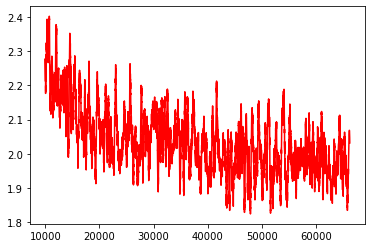

In [48]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(mse_list)
x = np.arange(len(y))
yhat = savgol_filter(y,501, 3) 

plt.plot(x[10000:], yhat[10000:], color='red')
plt.show()

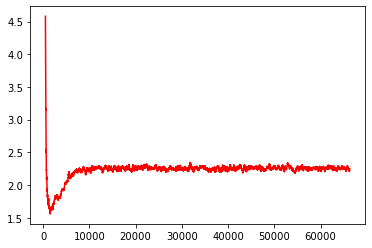

In [17]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(kld_list)
x = np.arange(len(y))
yhat = savgol_filter(y,501, 3) 

plt.plot(x[500:], yhat[500:], color='red')
plt.show()

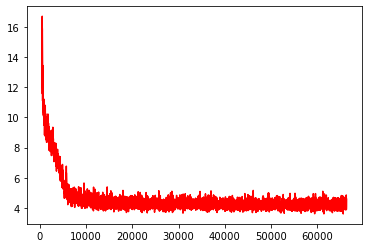

In [18]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(losses)
x = np.arange(len(y))
yhat = savgol_filter(y,51, 3) 

plt.plot(x[500:], yhat[500:], color='red')
plt.show()

In [19]:
torch.save(inference_net, "inference_2")

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type InferenceNetwork2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Active learning policy - PPO model and agent

In [228]:
class ActiveMetaIdentificationAgent:
    
    def __init__(self, ppo_agent, variational_inference_model, memory, prior, prev_latent_space):
        self.ppo_agent = ppo_agent
        self.q_net = variational_inference_model
        
        self.memory = memory
        
        self.prior = prior
        self.prev_latent_space = prev_latent_space
        
        self.posterior = prior
    
    # Setter
    def reset_posterior():
        self.posterior = self.prior
    
    def set_prior(self, prior):
        self.prior = prior
    
    def set_prev_latent_space(self, prev_latent_space):
        self.prev_latent_space = prev_latent_space
    
    # Action selection
    def select_action(self, state, memory):
        # Augment state with posterior
        state = torch.cat([state, posterior.flatten()])
        self.ppo_agent.select_action(state=state, memory=self.memory)
    
    # Update 
    def update_ppo_agent(self):
        self.ppo_agent.update(memory=self.memory)
        
    def update_posterior(self, action, state, env_reward, use_prev_state):
        # Use a sample from the environment (or a sequence of of sample)
        context = torch.cat([action, env_reward])
        _, mu_hat, logvar_hat = self.q_net(context=context, prev_z=self.prev_latent_space, prior=self.prior, use_prev_state=use_prev_state)
        self.posterior = torch.Tensor([mu_hat, logvar_hat.exp()])
        
    def update_reward(self, offset_star):
        # Compute reward
        reward = torch.sum(-(1/(2*self.posterior[1]))*(self.posterior[0]-offset_star).pow(2))
        self.memory.rewards.append(reward)
        
    def update_terminal_memory(self, done):
        self.memory.is_terminals.append(done)
        
    

In [215]:
for _ in range(meta_training_iter):
    # sample previous task and prior distribution on the next task
    prev_latent_space = torch.Tensor(param[torch.randint(low=0, high=n_tasks, size=(1,))])
    prior = prior_dist[torch.randint(low=0, high=n_tasks, size=(1,))]

    # sample current task from the prior 
    mu = prior[0]
    var = prior[1]
    
    offset_param = torch.normal(mu, var)
    new_task_latent_space = offset_param + prev_latent_space
    
    # Create environemnt for the current task
    env = SinMabEnv(amplitude=prev_latent_space[0],
                    frequency=prev_latent_space[2],
                    phase=prev_latent_space[1])
    
    # Interact with the environment for an episode and collect interactions and update the model 
    agent.set_prior(prior)
    agent.set_prev_latent_space(prev_latent_space)
    agent.reset_posterior()
    
    state = torch.Tensor([env.reset()])
    use_prev_state = False
    for i in range(horizon):
        action = torch.Tensor([agent.select_action(state)])
        state, env_reward, done, _ = env.step(action)
        
        state = torch.Tensor([state])
        
        # Update agent state and memory
        agent.update_posterior(action, state, env_reward, use_prev_state) # Update the posterior of the agent, and thus its state
        reward = agent.update_reward()
        agent.update_terminal_memory(done)
        
        # update if its time
        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
            
        running_reward += reward
        use_prev_state = True
        
        if done:
            break    

# Multi-task learning optimal policy

In [6]:
import gym
import gym_sin
import numpy as np
import time
from collections import deque
from gym import spaces


from ppo_a2c.model import Policy, MLPBase, ImprovedMLPBase
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.storage import RolloutStorage
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.utils import get_vec_normalize

In [7]:
# General parameters
device = "cpu"
env_name = "sin-v0"
seed = 0
gamma = None
log_dir = "."

# Training parameters
num_steps = 512
num_processes = 32

# PPO parametrs
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 8
value_loss_coef = 0.5
entropy_coef = 0.0
lr = 0.0001
eps = 1e-6
max_grad_norm=0.5

# Training parameters
use_linear_lr_decay = False
use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False
log_interval = 100
eval_interval = 1

In [227]:
base = MLPBase
obs_shape = (4,) # state + latent space of the current model
action_space = spaces.Box(low=np.array([-5]), high=np.array([5]))
actor_critic = Policy(obs_shape,
                      action_space, base=base,
                      base_kwargs={'recurrent': False,'hidden_size':64,'use_elu':True})

agent = PPO(actor_critic,
          clip_param,
          ppo_epoch,
          num_mini_batch,
          value_loss_coef,
          entropy_coef,
          lr=lr,
          eps=eps,
          max_grad_norm=max_grad_norm,
          use_clipped_value_loss=True)

episode_rewards = deque(maxlen=10)

In [229]:
def augment_obs(obs, latent, latent_dim, env_obs_shape):
    """
    Augment observation with the latent space
    
    Input
    - obs: observation from the environment (shape: (num_proc, env_obs_shape))
    - latent: list of tuples of latent parameters (size list: num proc, size tuple: latent dim)
    - latent_dim: dimension of the latent space
    - env_obs_shape: shape of the observation from the environment
    
    
    Output:
    - tensor of size (num_processes, latent_dim+env_obs_shape)
    """
    num_proc = obs.shape[0]
    new_obs = torch.empty((num_proc, latent_dim+env_obs_shape))
    
    for i in range(num_proc):
        new_obs[i] = torch.cat([obs[i], torch.Tensor(latent[i])])
    
    return new_obs

In [230]:
from functools import reduce

def multi_task_evaluate(actor_critic, env_name, seed, num_processes, eval_log_dir, device,
                       num_task_to_evaluate, latent_dim, env_obs_shape):
    assert num_task_to_evaluate % num_processes == 0
    
    print("Evaluation...")
    
    n_iter = num_task_to_evaluate // num_processes
    r_epi_list = []
    
    for i in range(n_iter):
        # Sample num_processes task at random
        curr_task_idx = np.random.randint(low=0, high=n_tasks, size=(num_processes,))
        # curr_task_idx = fixed_idx
        curr_latent = [param[i] for i in curr_task_idx]
    
        envs_kwargs = [{'amplitude':param[curr_task_idx[i]][0], 
                    'phase':param[curr_task_idx[i]][1],
                    'frequency':param[curr_task_idx[i]][2]} for i in range(num_processes)]
        eval_envs = make_vec_envs_multi_task(env_name,
                                        seed + num_processes, 
                                        num_processes,
                                        None,
                                        log_dir,
                                        device,
                                        False,
                                        envs_kwargs,
                                        num_frame_stack=None)
        
        eval_episode_rewards = []

        obs = eval_envs.reset()
        obs = augment_obs(obs, curr_latent, latent_dim, env_obs_shape)
        eval_recurrent_hidden_states = torch.zeros(
            num_processes, actor_critic.recurrent_hidden_state_size, device=device)
        eval_masks = torch.zeros(num_processes, 1, device=device)
        
        while len(eval_episode_rewards) < 10:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=True)

            # Obser reward and next obs
            obs, _, done, infos = eval_envs.step(action)
            obs = augment_obs(obs, curr_latent, latent_dim, env_obs_shape)
            
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=device)

            for info in infos:
                if 'episode' in info.keys():
                    total_epi_reward = info['episode']['r']
                    epi_len = info['episode']['l']
                    #amp = info['amp']
                    #eval_episode_rewards.append(total_epi_reward / (amp*epi_len))
                    eval_episode_rewards.append(total_epi_reward/epi_len)
                

        r_epi_list.append(eval_episode_rewards)
        eval_envs.close()
        
    r_epi_list = reduce(list.__add__, r_epi_list)
    print("Evaluation using {} tasks. Mean reward: {}".format(n_iter, np.mean(r_epi_list)))
    return np.mean(r_epi_list)

In [231]:
start = time.time()

meta_training_iter = 1000
num_update_per_meta_training_iter = 1
num_task_to_evaluate = 64

latent_dim = 3
env_obs_shape = 1

log_interval = 5
eval_interval = 20
eval_list = []

fixed_idx = np.random.randint(low=0, high=n_tasks, size=(1,))
fixed_idx = fixed_idx.repeat(64)

for j in range(meta_training_iter):
    # Sample new task
    curr_task_idx = np.random.randint(low=0, high=n_tasks, size=(num_processes,))
    # curr_task_idx = fixed_idx
    curr_latent = [param[i] for i in curr_task_idx]
    
    envs_kwargs = [{'amplitude':param[curr_task_idx[i]][0], 
                    'phase':param[curr_task_idx[i]][1],
                    'frequency':param[curr_task_idx[i]][2]} for i in range(num_processes)]
    envs = make_vec_envs_multi_task(env_name,
                                    seed, 
                                    num_processes,
                                    gamma,
                                    log_dir,
                                    device,
                                    False,
                                    envs_kwargs,
                                    num_frame_stack=None)
    obs = envs.reset()
    obs = augment_obs(obs, curr_latent, latent_dim, env_obs_shape)
    
    rollouts = RolloutStorage(num_steps, num_processes,
                              obs_shape, action_space,
                              actor_critic.recurrent_hidden_state_size)
    
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    for _ in range(num_update_per_meta_training_iter):
        # Collect observations and store them into the storage
        for step in range(num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Obser reward and next obs
            obs, reward, done, infos = envs.step(action)
            obs = augment_obs(obs, curr_latent, latent_dim, env_obs_shape)
            
            for info in infos:
                if 'episode' in info.keys():
                    episode_rewards.append(info['episode']['r'])

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)

        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, use_gae, 1,
                                 gae_lambda, use_proper_time_limits)

        value_loss, action_loss, dist_entropy = agent.update(rollouts)

        rollouts.after_update()

    if j % log_interval == 0 and len(episode_rewards) > 1:
            total_num_steps = (j + 1) * num_processes * num_steps
            end = time.time()
            print(
                "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
                .format(j, total_num_steps,
                        int(total_num_steps / (end - start)),
                        len(episode_rewards), np.mean(episode_rewards),
                        np.median(episode_rewards), np.min(episode_rewards),
                        np.max(episode_rewards), dist_entropy, value_loss,
                        action_loss))
    
    if (eval_interval is not None and j % eval_interval == 0 and j>1):
        e = multi_task_evaluate(actor_critic, env_name, seed, num_processes, ".", device,
                            num_task_to_evaluate, latent_dim, env_obs_shape)
        eval_list.append(e)

Updates 0, num timesteps 16384, FPS 3533 
 Last 10 training episodes: mean/median reward 16.0/13.5, min/max reward -26.3/70.0

Updates 5, num timesteps 98304, FPS 3768 
 Last 10 training episodes: mean/median reward 26.2/12.3, min/max reward -48.4/85.4

Updates 10, num timesteps 180224, FPS 3998 
 Last 10 training episodes: mean/median reward 14.6/16.9, min/max reward -63.6/71.0

Updates 15, num timesteps 262144, FPS 4078 
 Last 10 training episodes: mean/median reward -25.4/-23.2, min/max reward -75.9/20.7

Updates 20, num timesteps 344064, FPS 4143 
 Last 10 training episodes: mean/median reward 37.2/45.6, min/max reward -14.1/65.0

Evaluation...
Evaluation using 2 tasks. Mean reward: 0.17977598677083334
Updates 25, num timesteps 425984, FPS 4123 
 Last 10 training episodes: mean/median reward 12.9/19.1, min/max reward -61.0/78.9

Updates 30, num timesteps 507904, FPS 4117 
 Last 10 training episodes: mean/median reward 25.6/48.8, min/max reward -79.2/81.5

Updates 35, num timesteps 

Updates 280, num timesteps 4603904, FPS 4452 
 Last 10 training episodes: mean/median reward 41.2/47.0, min/max reward -25.7/106.9

Evaluation...
Evaluation using 2 tasks. Mean reward: 0.6486402026041667
Updates 285, num timesteps 4685824, FPS 4447 
 Last 10 training episodes: mean/median reward 53.2/61.2, min/max reward -60.0/111.9

Updates 290, num timesteps 4767744, FPS 4437 
 Last 10 training episodes: mean/median reward 42.6/71.3, min/max reward -94.7/99.1

Updates 295, num timesteps 4849664, FPS 4426 
 Last 10 training episodes: mean/median reward 69.3/67.4, min/max reward 16.2/108.8

Updates 300, num timesteps 4931584, FPS 4422 
 Last 10 training episodes: mean/median reward 57.8/80.7, min/max reward -106.1/119.5

Evaluation...
Evaluation using 2 tasks. Mean reward: 0.48395114437500003
Updates 305, num timesteps 5013504, FPS 4416 
 Last 10 training episodes: mean/median reward 63.1/78.1, min/max reward -61.2/101.3

Updates 310, num timesteps 5095424, FPS 4395 
 Last 10 training 

Updates 555, num timesteps 9109504, FPS 3526 
 Last 10 training episodes: mean/median reward 72.7/94.4, min/max reward -38.2/129.4

Updates 560, num timesteps 9191424, FPS 3516 
 Last 10 training episodes: mean/median reward 90.3/99.9, min/max reward 34.3/124.6

Evaluation...
Evaluation using 2 tasks. Mean reward: 0.5913321108333334
Updates 565, num timesteps 9273344, FPS 3504 
 Last 10 training episodes: mean/median reward 48.2/63.0, min/max reward -84.1/94.6

Updates 570, num timesteps 9355264, FPS 3494 
 Last 10 training episodes: mean/median reward 73.3/104.3, min/max reward -71.9/129.1

Updates 575, num timesteps 9437184, FPS 3486 
 Last 10 training episodes: mean/median reward 101.1/103.1, min/max reward 67.8/126.2

Updates 580, num timesteps 9519104, FPS 3477 
 Last 10 training episodes: mean/median reward 58.1/83.5, min/max reward -95.9/130.2

Evaluation...
Evaluation using 2 tasks. Mean reward: 0.572112010625
Updates 585, num timesteps 9601024, FPS 3466 
 Last 10 training epis

KeyboardInterrupt: 

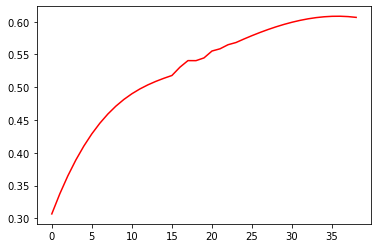

In [239]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(eval_list)
x = np.arange(len(y))
yhat = savgol_filter(y,31, 3) 

plt.plot(x, yhat, color='red')
plt.show()

# Identification policy

In [49]:
import gym
import gym_sin
import numpy as np
import time
from collections import deque
from gym import spaces
import torch


from ppo_a2c.model import Policy, MLPBase, ImprovedMLPBase
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.storage import RolloutStorage
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.utils import get_vec_normalize
from ppo_a2c.envs import RewardSmoother, ObsSmoother, AdvancedRewardSmoother

In [623]:
inference_net = torch.load("inference_2")

In [674]:
# General parameters
device = "cpu"
env_name = "gauss-v0"
seed = 0
gamma = 0.9
log_dir = "."

# Training parameters
num_steps = 30
num_processes = 32

# PPO parametrs
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 8
value_loss_coef = 0.5
entropy_coef = 0.001
lr = 0.00001
eps = 1e-6
max_grad_norm=0.5

# Training parameters
use_linear_lr_decay = False
use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False

# A2C
base = MLPBase
obs_shape = (4,) # state + latent space of the current model
action_space = spaces.Box(low=-1., high=1., shape=(1,), dtype="float")
actor_critic = Policy(obs_shape,
                      action_space, base=base,
                      base_kwargs={'recurrent':False,'hidden_size':16,'use_elu':True})

# PPO 
agent = PPO(actor_critic,
          clip_param,
          ppo_epoch,
          num_mini_batch,
          value_loss_coef,
          entropy_coef,
          lr=lr,
          eps=eps,
          max_grad_norm=max_grad_norm,
          use_clipped_value_loss=True)

# Reward log structure
episode_rewards = deque(maxlen=10)

In [675]:
def get_mse(posterior, offset_star, latent_dim):
    if type(posterior) == list:
        posterior = torch.tensor([posterior[i].flatten().tolist() for i in range(num_processes)])
    return F.mse_loss(posterior[:, 0:latent_dim], offset_star)

In [676]:
def get_reward(posterior, offset_star, latent_dim):
    like = get_like(posterior, offset_star, latent_dim)
    return like

In [677]:
def get_posterior(variational_model, action, reward, prior, prev_latent_space, use_prev_state=True):
    """
    Feed the variational model with the actual reward to identifiy the latent space
    and get the current reward using the posterior and the true task
    """
    num_proc = action.shape[0]
    prev_latent_space = torch.tensor(prev_latent_space)
    flatten_prior = torch.tensor([prior[i].flatten().tolist() for i in range(num_processes)])
    
    # To feed VI, i need (n_batch, 1, 2)
    context = torch.empty(num_proc, 1, 2)
    for i in range(num_proc):
        t = (100 - (-100))/(1 -(-1)) * (action[i] - 1) + 100
        context[i] = torch.cat([t, reward[i]])
    
    posterior = variational_model(context=context, prev_z=prev_latent_space, prior=flatten_prior, use_prev_state=use_prev_state)
    posterior = posterior[1:]
    posterior = torch.cat([posterior[0].detach(), posterior[1].detach()], 1)
    return posterior

In [678]:
def rescale_latent(num_proc, old_var, latent_dim):
    rescaled_latent = []
    
    max_old = [40, 35]
    min_old = [-40, 15]
    
    for i in range(num_proc):
        new = []
        for j in range(latent_dim):
            t = (1 - (-1)) / (max_old[j] - min_old[j]) * (old_var[i][j] - max_old[j]) + 1
            if t > 1:
                print("Exceeding max in latent dim {}".format(j))
                t = 1.
            elif t < -1:
                print("Exceeding min in latent dim {}".format(j))
                t = -1
            new.append(t)
        rescaled_latent.append(new)
    return rescaled_latent

def rescale_posterior(num_proc, old_var, latent_dim):
    rescaled_posterior = []
    
    max_old = [100, 50, 20, 20]
    min_old = [-100, 0, 0, 0]
    
    for i in range(num_proc):
        new = []
        for j in range(latent_dim * 2):
            t = (1 - (-1)) / (max_old[j] - min_old[j]) * (old_var[i][j] - max_old[j]) + 1
            if t > 1:
                print("Exceeding max in posterior dim {}".format(j))
                t = 1.
            elif t < -1:
                print("Exceeding min in posterior dim {}".format(j))
                t = -1
            new.append(t)
        rescaled_posterior.append(new)
        
    return torch.tensor(rescaled_posterior)

In [679]:
def al_augment_obs(obs, prev_latent, latent_dim, env_obs_shape, posterior, prior,rescale_obs=True):
    num_proc = obs.shape[0]
    #new_obs = torch.empty((num_proc, 3*latent_dim+env_obs_shape))
    new_obs = torch.empty((num_proc, 2*latent_dim))
    
    prior = torch.tensor([prior[i].flatten().tolist() for i in range(num_processes)])
    
    if(type(posterior) == list):
        posterior = torch.tensor([posterior[i].flatten().tolist() for i in range(num_processes)])
    else:
        posterior[:, latent_dim:] = posterior[:, latent_dim:].exp()
    
    if rescale_obs:
        #prev_latent = rescale_latent(num_proc, prev_latent, latent_dim)
        posterior = rescale_posterior(num_proc, posterior, latent_dim)
        prior = rescale_posterior(num_proc, prior, latent_dim)
    
    for i in range(num_proc): 
        # new_obs[i] = torch.cat([obs[i], torch.Tensor(prev_latent[i]),posterior[i]])
        new_obs[i] = posterior[i]
    
    return new_obs

In [680]:
def get_like(posterior, offset_star, latent_dim):
    if type(posterior) == list:
        posterior = torch.tensor([posterior[i].flatten().tolist() for i in range(num_processes)])
        posterior[:, latent_dim:] = posterior[:, latent_dim:].log()
    
    l = torch.sum(-(1/(2*posterior[:, latent_dim:].exp()))*(posterior[:, 0:latent_dim]-offset_star).pow(2), 1).unsqueeze(1)  
    return l

def get_best_like(vi, num_proc, num_r, tasks, prior, prev_t, latent_dim, n_samples=30):
    # Retrieve tasks
    num_t = num_proc // num_r
    t = torch.empty((num_t, latent_dim))
    p = torch.empty((num_t, 2 * latent_dim))
    z = torch.empty((num_t, latent_dim))
    
    for i in range(num_t):
        t[i] = tasks[i * num_r].clone().detach()
        p[i] = prior[i * num_r].flatten().clone().detach()
        z[i] = torch.tensor([prev_t[i * num_r]])
    
    # Retrieve informative data
    context = torch.empty((num_t, n_samples, 2))
    for i in range(num_t):
        x_space = torch.arange(-100, 100, 0.01)
        f_space = torch.exp(-((x_space - t[i][0]) ** 2) / (t[i][1] ** 2))
        w = f_space / f_space.sum()
        temp = torch.multinomial(w, n_samples, replacement=True)
        x = x_space[temp]
        y = torch.exp(-((x-t[i,0])**2)/(t[i, 1]**2))
        context[i, :, 0] = x
        context[i, :, 1] = y
        
    # Compute posterior and likelihood
    res = vi(context=context, prior=p, prev_z=z)[1:]
    post = torch.empty((num_t, latent_dim * 2))
    for i in range(num_t):
        post[i] = torch.cat([res[0][i, :], res[1][i, :]])
    for i in range(num_t):
        p[i][latent_dim:] = p[i][latent_dim:].log()
    
    best = torch.empty((num_proc, 1))
    like_post = get_like(post, t, latent_dim)
    for i in range(num_t):
         for j in range(num_r):
                best[(i*num_r)+j] = like_post[i]
    
    return best.detach()

In [681]:
from functools import reduce

def identification_evaluate(actor_critic, vi, env_name, seed, num_processes, eval_log_dir, device,
                            num_task_to_evaluate, latent_dim, env_obs_shape, max_horizon=150):
    assert num_task_to_evaluate % num_processes == 0
    
    n_iter = num_task_to_evaluate // num_processes
    reward_iter = torch.zeros(num_processes, max_horizon)
    r_list = []
    mse_list_at_horizon = []
    mse_list_at_10 = []
    mse_list_at_50 = []
    mse_list_at_0 = []
    
    for i in range(n_iter):
        prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
        prev_task = [param[prev_task_idx[i]] for i in range(num_processes,)]

        prior_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
        prior = [prior_dist[prior_idx[i]].clone().detach() for i in range(num_processes)]

        # Sample current task from the prior 
        mu = [prior[i][0].clone().detach() for i in range(num_processes)]
        var = [prior[i][1].clone().detach() for i in range(num_processes)]

        offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
        offset_param = torch.tensor(offset_param)

        # Modify the prior
        for i in range(num_processes):
            prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

        mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
        new_tasks = offset_param + torch.tensor(prev_task)    
        

        # Sample new task
        envs_kwargs = [{'amplitude':1, 
                        'mean':new_tasks[i][0].item(),
                        'std':new_tasks[i][1].item(),
                        'noise_std':0.001,
                        'scale_reward':False} for i in range(num_processes)]
        
        obs_rms_eval = ObsSmootherTemp(obs_shape=(7,))
        
        eval_envs = make_vec_envs_multi_task(env_name,
                                        seed, 
                                        num_processes,
                                        None,
                                        log_dir,
                                        device,
                                        False,
                                        envs_kwargs,
                                        num_frame_stack=None)

        obs = eval_envs.reset()
        obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, prior, prior)
        
        obs = obs_rms_eval.step(obs)
        
        epi_done = []

        eval_recurrent_hidden_states = torch.zeros(
            num_processes, actor_critic.recurrent_hidden_state_size, device=device)
        eval_masks = torch.zeros(num_processes, 1, device=device)
        
        t=0 
        
        use_prev_state = False
        while len(epi_done) < num_processes:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=False)

            # Obser reward and next obs
            if t == 0:
                mse_list_at_0.append(get_mse(prior, new_tasks, 2).item())
            
            obs, reward, done, infos = eval_envs.step(action)
            posterior = get_posterior(vi, action, reward, prior, prev_task, use_prev_state=use_prev_state)
            reward = get_reward(posterior, new_tasks, latent_dim)
            obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, posterior, prior)
            obs = obs_rms_eval.step(obs)
            use_prev_state = True
            reward_iter[:, t] = reward.squeeze()
            t = t+1
            
            if t == 10:
                mse_list_at_10.append(get_mse(posterior, new_tasks, 2).item())
            if t == 50:
                mse_list_at_50.append(get_mse(posterior, new_tasks, 2).item())
            
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=device)

            for info in infos:
                if 'episode' in info.keys():
                    epi_done.append(True)
            
        mse_list_at_horizon.append(get_mse(posterior, new_tasks, 2).item())
        r_list.append(reward_iter)
        eval_envs.close()
        
    mean_mse_0 = np.mean(mse_list_at_0)
    mean_mse_horizon = np.mean(mse_list_at_horizon)
    mean_mse_10 = np.mean(mse_list_at_10)
    mean_mse_50 = np.mean(mse_list_at_50)
    mean_r = np.mean(reduce(list.__add__, [torch.sum(elem, 1).tolist() for elem in r_list]))
    print("Evaluation using {} tasks. Mean reward: {}. Mean MSE: {:.2f} || {:.2f} || {:.2f} || {:.2f}".
          format(n_iter*num_processes, mean_r, mean_mse_0, mean_mse_10, mean_mse_50, mean_mse_horizon))
    return mean_r, r_list

In [ ]:
start = time.time()

meta_training_iter = 100000
num_update_per_meta_training_iter = 1
num_task_to_evaluate = num_processes

latent_dim = 2
env_obs_shape = 1
obs_dim = 4

num_processes  = 32
log_interval = 5
eval_interval = 1
# eval_list = []

variational_model = inference_net

num_replicas = 2
num_different =  num_processes // num_replicas


for k in range(meta_training_iter):   
    # Sample previous task and prior distribution on the next task
    prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_different,))
    prev_task = []
    for i in range(num_different):
        for j in range(num_replicas):
            prev_task.append(param[prev_task_idx[i]])

    prior_idx = torch.randint(low=0, high=n_tasks, size=(num_different,))
    prior = []
    for i in range(num_different):
        for j in range(num_replicas):
            prior.append(prior_dist[prior_idx[i]].clone().detach())

    # Sample current task from the prior 
    mu = [prior[i][0].clone().detach() for i in range(num_processes)]
    var = [prior[i][1].clone().detach() for i in range(num_processes)]

    sample = []
    for i in range(num_different):
        sample.append(torch.normal(mu[i*num_replicas], var[i*num_replicas]).tolist())

    offset_param = []
    for i in range(num_different):
        for j in range(num_replicas):
            offset_param.append(sample[i])
    offset_param = torch.tensor(offset_param)

    # Modify the prior
    for i in range(num_processes):
        prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

    mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
    new_tasks = offset_param + torch.tensor(prev_task)
    
    # Sample new task
    envs_kwargs = [{'amplitude':1, 
                    'mean':new_tasks[i][0].item(),
                    'std':new_tasks[i][1].item(),
                    'noise_std':0.001,
                    'scale_reward':False} for i in range(num_processes)]
    
    envs = make_vec_envs_multi_task(env_name,
                                    seed, 
                                    num_processes,
                                    None,
                                    log_dir,
                                    device,
                                    False,
                                    envs_kwargs,
                                    num_frame_stack=None)
    
    obs = envs.reset()
    obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, prior, prior)
    
    rollouts = RolloutStorage(num_steps, num_processes,
                              obs_shape, action_space,
                              actor_critic.recurrent_hidden_state_size)
    
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    use_prev_state = False
    
    rms = FakeRewardSmoother()
    # rms = AdvancedRewardSmoother(num_processes, num_replicas, gamma=gamma)
    # rms = RewardSmoother(num_envs=num_processes, cliprew=10, gamma=gamma)
    obs_rms = ObsSmootherTemp(obs_shape=(7,))
    obs = obs_rms.step(obs)
    
    for _ in range(num_update_per_meta_training_iter):
        # Collect observations and store them into the storage
        for step in range(num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Obser reward and next obs
            obs, reward, done, infos = envs.step(action)
            posterior = get_posterior(variational_model, action, reward, prior, prev_task, use_prev_state=use_prev_state)
            use_prev_state = True
            
            reward_prev = get_reward(posterior, new_tasks, latent_dim)
            reward = rms.step(reward_prev, done)
            obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, posterior, prior)
            obs = obs_rms.step(obs)
            
            # If done then clean the history of observations.
            if done.any():
                use_prev_state = False
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)
    
        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, use_gae, gamma,
                                 gae_lambda, use_proper_time_limits)

        value_loss, action_loss, dist_entropy = agent.update(rollouts)

        rollouts.after_update()
        
    rms.reset()
    eval_interval = 10
    if (eval_interval is not None and k % eval_interval == 0 and k>1):
        e = identification_evaluate(actor_critic, inference_net,env_name, seed, num_processes, ".", device,
                                    32, latent_dim, env_obs_shape)
        eval_list.append(e)

Evaluation using 32 tasks. Mean reward: -607.4079916477203. Mean MSE: 10.83 || 3.03 || 1.40 || 1.09
Evaluation using 32 tasks. Mean reward: -810.5978345870972. Mean MSE: 8.53 || 4.32 || 2.17 || 1.63
Evaluation using 32 tasks. Mean reward: -699.984398663044. Mean MSE: 7.68 || 3.85 || 1.85 || 1.25
Evaluation using 32 tasks. Mean reward: -971.2994099855423. Mean MSE: 11.33 || 6.68 || 2.21 || 1.81
Evaluation using 32 tasks. Mean reward: -1417.4176746606827. Mean MSE: 14.12 || 9.08 || 3.76 || 3.23
Evaluation using 32 tasks. Mean reward: -1060.8563741445541. Mean MSE: 9.17 || 6.80 || 2.37 || 2.55
Evaluation using 32 tasks. Mean reward: -980.0430728793144. Mean MSE: 8.60 || 6.59 || 2.17 || 2.59
Evaluation using 32 tasks. Mean reward: -634.6094336509705. Mean MSE: 7.21 || 3.33 || 1.45 || 1.04
Evaluation using 32 tasks. Mean reward: -1468.885609060526. Mean MSE: 11.99 || 8.35 || 4.29 || 3.35
Evaluation using 32 tasks. Mean reward: -679.3456436395645. Mean MSE: 7.66 || 3.21 || 1.64 || 1.31
Evalu

In [697]:
k

1580

In [687]:
class FakeRewardSmoother:
    def __init__(self):
        pass

    def step(self, reward, done):
        return reward

    def reset(self):
        pass

In [58]:
from baselines.common.running_mean_std import RunningMeanStd

class ObsSmootherTemp:
    def __init__(self, obs_shape, clipob=10., epsilon=1e-8):
        self.clipob = clipob
        self.epsilon = epsilon
        self.ob_rms = RunningMeanStd(shape=obs_shape)

    def step(self, obs):
        return obs
        #obs = obs.numpy()
        #self.ob_rms.update(obs)
        #obs = np.clip((obs - self.ob_rms.mean) / np.sqrt(self.ob_rms.var + self.epsilon), -self.clipob, self.clipob)
        #return torch.tensor(obs, dtype=torch.float32)

In [ ]:
"""
MULTI TASK SINGLE BATCH

# Sample previous task and prior distribution on the next task
prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
prev_task = [param[prev_task_idx[i]] for i in range(num_processes,)]

prior_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
prior = [prior_dist[prior_idx[i]].clone().detach() for i in range(num_processes)]

# Sample current task from the prior 
mu = [prior[i][0].clone().detach() for i in range(num_processes)]
var = [prior[i][1].clone().detach() for i in range(num_processes)]

offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
offset_param = torch.tensor(offset_param)

# Modify the prior
for i in range(num_processes):
    prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
new_tasks = offset_param + torch.tensor(prev_task)
"""

In [ ]:
"""
SINGLE TASK MULTI BATCH

prev_task_idx = torch.randint(low=0, high=n_tasks, size=(1,))
prev_task = [param[prev_task_idx[0]] for _ in range(num_processes)]

prior_idx = torch.randint(low=0, high=n_tasks, size=(1,))
prior = [prior_dist[prior_idx[0]].clone().detach() for i in range(num_processes)]

# Sample current task from the prior 
mu = [prior[0][0].clone().detach() for _ in range(num_processes)]
var = [prior[0][1].clone().detach() for _ in range(num_processes)]

sample = torch.normal(mu[0], var[0]).tolist()
offset_param = [sample for _ in range(num_processes)]
offset_param = torch.tensor(offset_param)

# Modify the prior
for i in range(num_processes):
    prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
new_tasks = offset_param + torch.tensor(prev_task)"""

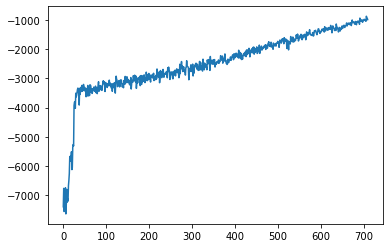

In [140]:
l = [eval_list[i][0] for i in range(len(eval_list))]
plt.plot(l)

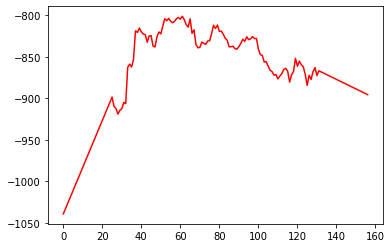

1580


In [696]:
import numpy as np
from scipy.signal import savgol_filter

l = [eval_list[i][0] for i in range(len(eval_list))]

y = np.array(l)
x = np.arange(len(y))
yhat = savgol_filter(y, 51, 1) 

plt.plot(x, yhat, color='red')
#plt.plot(l)
plt.show()
print(k)

# VI behavior

In [21]:
def get_posterior_debug(variational_model, action, reward, prior, prev_latent_space, use_prev_state=True):
    """
    Feed the variational model with the actual reward to identifiy the latent space
    and get the current reward using the posterior and the true task
    """
    #prev_latent_space = torch.tensor(prev_latent_space)
    num_proc=1
    flatten_prior = torch.tensor([prior.flatten().tolist() for i in range(num_proc)])[0]
    
    # To feed VI, i need (n_batch, 1, 2)
    context = torch.empty(num_proc, 1, 2)
    for i in range(num_proc):
        context[i] = torch.cat([torch.tensor([action.item()]), torch.tensor([reward.item()])])
    
    posterior = variational_model(context=context, prev_z=prev_latent_space, prior=flatten_prior, use_prev_state=use_prev_state)
    posterior = posterior[1:]
    posterior = torch.cat([posterior[0].detach(), posterior[1].detach()], 1)
    return posterior

In [19]:
inference_net = torch.load("inference")

In [630]:
init_loss = []
sum_reward = []
final_loss = []
for i in range(32):
    # Choose pair of init task and distribution for the next task
    task_idx = torch.randint(low=0, high=n_tasks, size=(10,))
    task_loader = [data_set[i] for i in task_idx]
    target = torch.tensor([param[i] for i in task_idx])

    prev_task_param = torch.randint(low=0, high=n_tasks, size=(10,))

    prior = torch.empty(10, 4)
    mu_prior = torch.empty(10, 2)
    logvar_prior = torch.empty(10, 2)
    for t_idx in range(10):
        prior[t_idx] = prior_dist[prev_task_param[t_idx]].reshape(1, 4).squeeze(0)
        mu_prior[t_idx] = prior_dist[prev_task_param[t_idx]][0] 
        logvar_prior[t_idx] = prior_dist[prev_task_param[t_idx]][1].log()


    prev_task = torch.empty(10, 2)
    # Creating new task
    mu = prior_dist[prev_task_param[0]][0]
    var = prior_dist[prev_task_param[0]][1]

    offset_param = torch.normal(mu, var)

    prev_task[0] = target[0] - offset_param 
    prior[0][0:2] = prev_task[0] + prior[0][0:2] 
    mu_prior[0] = prev_task[0] + mu_prior[0]  

    #print("Mu prior {}".format(prior_dist[prev_task_param[0]][0]))
    #print("Mu var {}".format(prior_dist[prev_task_param[0]][1]))
    #print("Offset {}".format(offset_param))
    #print("Difference from mu prior {}".format(torch.abs(target[0] - mu_prior[0])))

    # Generate data 125
    x_space = torch.arange(-100, 100, 0.01)
    f_space = torch.exp(-((x_space - prior[0][0]) ** 2) / (prior[0][1] ** 2))
    w = f_space / f_space.sum()
    temp = torch.multinomial(w, 1, replacement=True)
    x = x_space[temp]
    y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))

    loss_list = []
    like_list = []
    loss_list.append(F.mse_loss(prior[0][0:2], target[0]).item())
    for i in range(150):
        use_prev_state = True if i > 0 else False
        posterior = get_posterior_debug(inference_net, x, y, prior[0], prev_task[0], use_prev_state=use_prev_state)
        loss_list.append(F.mse_loss(posterior[0][0:2], target[0]).item())
        l = torch.sum(-(1/(2*posterior[0, latent_dim:].clone().detach().exp()))*(posterior[0, 0:latent_dim]-target[0]).pow(2)) 
        like_list.append(l)
        
        #f_space = torch.exp(-((x_space - posterior[0][0]) ** 2) / (posterior[0][1].exp() ** 2))
        #w = f_space / f_space.sum()
        #temp = torch.multinomial(w, 1, replacement=True)
        #x = x_space[temp]
        x = torch.normal(mean=torch.tensor([posterior[0][0]]), std=torch.tensor([posterior[0][1]]))
        y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))
        
    
    #plt.plot(loss_list)
    #print(loss_list[0])
    #print(loss_list[-1])
    sum_reward.append(np.sum(like_list))
    init_loss.append(loss_list[0])
    final_loss.append(loss_list[10])
print("Avg sum reward {}".format(np.mean(sum_reward)))
print("Avg init loss {}".format(np.mean(init_loss)))
print("Avg fin loss {}".format(np.mean(final_loss)))

Avg sum reward -293.7804260253906
Avg init loss 5.561309067765251
Avg fin loss 1.392934682779014


Avg init loss 7.092361334897578
Avg fin loss 3.1952686863578856


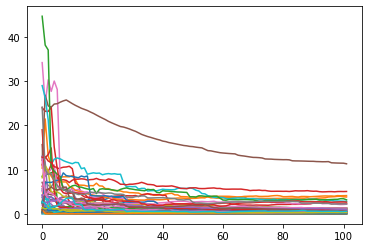

In [474]:
init_loss = []
final_loss = []
num_processes=4
for i in range(50):
    # Sample previous task and prior distribution on the next task
    prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    prev_task = [param[prev_task_idx[i]] for i in range(num_processes,)]

    prior_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    prior = [prior_dist[prior_idx[i]].clone().detach() for i in range(num_processes)]

    # Sample current task from the prior 
    mu = [prior[i][0].clone().detach() for i in range(num_processes)]
    var = [prior[i][1].clone().detach() for i in range(num_processes)]

    offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
    offset_param = torch.tensor(offset_param)

    # Modify the prior
    for i in range(num_processes):
        prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

    mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
    new_tasks = offset_param + torch.tensor(prev_task)    

    # Generate data 125
    #x_space = torch.arange(-100, 100, 0.01)
    #f_space = torch.exp(-((x_space - new_tasks[0][0]) ** 2) / (new_tasks[0][1] ** 2))
    #w = f_space / f_space.sum()
    #temp = torch.multinomial(w, 1000, replacement=True)
    temp = torch.randint(low=0, high=x_space.shape[0],size=(101,))
    x = x_space[temp]
    y = torch.exp(-((x-new_tasks[0,0])**2)/(new_tasks[0, 1]**2))

    loss_list = []
    loss_list.append(F.mse_loss(prior[0][0, 0:2], new_tasks[0]).item())
    for i in range(101):
        use_prev_state = True if i > 0 else False
        posterior = get_posterior_debug(inference_net, x[i], y[i], prior[0], torch.tensor(prev_task[0]), use_prev_state=use_prev_state)
        loss_list.append(F.mse_loss(posterior[0][0:2], new_tasks[0]).item())
        #if i == 100 or i == 1:
        #    print("Posterior var {}".format(posterior[0][2:].exp()))

    plt.plot(loss_list)
    #print(loss_list[0])
    #print(loss_list[-1])
    init_loss.append(loss_list[0])
    final_loss.append(loss_list[10])
print("Avg init loss {}".format(np.mean(init_loss)))
print("Avg fin loss {}".format(np.mean(final_loss)))

# Advanced r smoother

In [32]:
import gym_sin
import gym
import numpy as np
import torch
from baselines.common.running_mean_std import RunningMeanStd
from ppo_a2c.envs import make_vec_envs_multi_task

In [33]:
num_processes = 3
num_replicas = 4
m_list = [1, 0, 3]

envs_kwargs = []
for i in range(num_processes):
    for j in range(num_replicas):
        envs_kwargs.append({'amplitude':1, 
                            'mean':m_list[i],
                            'noise_std':0.1,
                            'scale_reward':False})
envs = make_vec_envs_multi_task("gauss-v0",
                                0, 
                                num_processes * num_replicas,
                                None,
                                "",
                                "cpu",
                                False,
                                envs_kwargs,
                                num_frame_stack=None)
envs.reset()

action = torch.zeros((12,1))

In [34]:
t = AdvancedRewardSmoother(12, 4)

In [39]:
done = np.zeros(12, dtype=np.bool)
t.step(envs.step(action)[1], done)

[0.47882012 0.41143295 0.33485395 0.2639159 ]
0.27436877176496677
[1.0112797 0.8660337 0.9394092 1.0307221]
1.6817215297378991
[-0.11872538  0.09042202 -0.2617215  -0.05591686]
0.00429864095215179


tensor([[ 0.9141],
        [ 0.7855],
        [ 0.6393],
        [ 0.5038],
        [ 0.7798],
        [ 0.6678],
        [ 0.7244],
        [ 0.7948],
        [-1.8108],
        [ 1.3791],
        [-3.9918],
        [-0.8529]])

In [97]:
num_processes = 32
num_replicas = 8
num_different =  num_processes // num_replicas

# Sample previous task and prior distribution on the next task
prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_different,))
prev_task = []
for i in range(num_different):
    for j in range(num_replicas):
        prev_task.append(param[prev_task_idx[i]])
        
prior_idx = torch.randint(low=0, high=n_tasks, size=(num_different,))
prior = []
for i in range(num_different):
    for j in range(num_replicas):
        prior.append(prior_dist[prior_idx[i]].clone().detach())

# Sample current task from the prior 
mu = [prior[i][0].clone().detach() for i in range(num_processes)]
var = [prior[i][1].clone().detach() for i in range(num_processes)]

sample = []
for i in range(num_different):
    sample.append(torch.normal(mu[i*num_replicas], var[i*num_replicas]).tolist())

offset_param = []
for i in range(num_different):
    for j in range(num_replicas):
        offset_param.append(sample[i])
offset_param = torch.tensor(offset_param)

# Modify the prior
for i in range(num_processes):
    prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
new_tasks = offset_param + torch.tensor(prev_task)

In [107]:
t = []
for i in range(num_processes):
    t.append(F.mse_loss(prior[i][0, :], new_tasks[i]).item())
np.mean(t)

2.469937600195408

In [83]:
prior[20]

tensor([[-18.0502,  25.0032],
        [  2.1776,   3.9712]])

In [84]:
new_tasks[20]

tensor([-14.3669,  30.4350])

In [106]:
for t in range(num_processes):
    # Generate data 125
    x_space = torch.arange(-100, 100, 0.01)
    f_space = torch.exp(-((x_space - new_tasks[t][0]) ** 2) / (new_tasks[t][1] ** 2))
    w = f_space / f_space.sum()
    temp = torch.multinomial(w, 1000, replacement=True)
    x = x_space[temp]
    y = torch.exp(-((x-new_tasks[t,0])**2)/(new_tasks[t, 1]**2))

    loss_list = []
    loss_list.append(F.mse_loss(prior[t][0, 0:2], new_tasks[t]).item())
    for i in range(101):
        use_prev_state = True if i > 0 else False
        posterior = get_posterior_debug(inference_net, x[i], y[i], prior[t], torch.tensor(prev_task[t]), use_prev_state=use_prev_state)
        loss_list.append(F.mse_loss(posterior[0][0:2], new_tasks[t]).item())
    print(loss_list[0])
    print(loss_list[-1])

0.7128336429595947
0.08723463118076324
0.7128336429595947
0.12415207922458649
0.7128336429595947
0.11389371007680893
0.7128336429595947
0.10019300878047943
0.7128336429595947
0.06337092071771622
0.7128336429595947
0.1333964765071869
0.7128336429595947
0.16259777545928955
0.7128336429595947
0.18438328802585602
0.21788659691810608
0.18070116639137268
0.21788659691810608
0.20166794955730438
0.21788659691810608
0.16294550895690918
0.21788659691810608
0.18427328765392303
0.21788659691810608
0.20918014645576477
0.21788659691810608
0.2297196388244629
0.21788659691810608
0.19371987879276276
0.21788659691810608
0.18246062099933624
6.06727409362793
0.700543999671936
6.06727409362793
1.6068830490112305
6.06727409362793
1.291049599647522
6.06727409362793
1.2394598722457886
6.06727409362793
1.4175664186477661
6.06727409362793
0.8629227876663208
6.06727409362793
0.8213313221931458
6.06727409362793
0.6555339097976685
2.881756067276001
0.1465175449848175
2.881756067276001
0.27948224544525146
2.8817560

In [104]:
posterior

tensor([[-9.4180, 19.7580, -1.1599, -1.2346]])

In [150]:
prior[0].flatten()

tensor([27.2093, 29.9131,  3.6074,  2.0837])

tensor([[-0.3974],
        [-0.3974],
        [-0.3974],
        [-0.3974],
        [-0.3974],
        [-0.3974],
        [-0.3974],
        [-0.3974],
        [-2.5857],
        [-2.5857],
        [-2.5857],
        [-2.5857],
        [-2.5857],
        [-2.5857],
        [-2.5857],
        [-2.5857],
        [-2.7978],
        [-2.7978],
        [-2.7978],
        [-2.7978],
        [-2.7978],
        [-2.7978],
        [-2.7978],
        [-2.7978],
        [-0.4364],
        [-0.4364],
        [-0.4364],
        [-0.4364],
        [-0.4364],
        [-0.4364],
        [-0.4364],
        [-0.4364]], grad_fn=<CopySlices>)

In [327]:
best

tensor([[-3.2569],
        [-3.2569],
        [-3.2569],
        [-3.2569],
        [-3.2569],
        [-3.2569],
        [-3.2569],
        [-3.2569],
        [-0.9700],
        [-0.9700],
        [-0.9700],
        [-0.9700],
        [-0.9700],
        [-0.9700],
        [-0.9700],
        [-0.9700],
        [-4.9230],
        [-4.9230],
        [-4.9230],
        [-4.9230],
        [-4.9230],
        [-4.9230],
        [-4.9230],
        [-4.9230],
        [-1.7108],
        [-1.7108],
        [-1.7108],
        [-1.7108],
        [-1.7108],
        [-1.7108],
        [-1.7108],
        [-1.7108]])